This file is intended to process the original data and put out easily accesible data. 

The result should be two csv files:
    consumption.csv
    pv_production.csv

Both files should cover the same timespan.
The unit should be kWh/hh (kwH per half hour). Hence we can simply check how much energy is produced/consumed 
in a half hour timeframe.

+++ pv_production.csv +++ 

Power generation of solar panels on an half hourly rate.
To create this file you have to find an appropriate way to mean the values of three ten minute intervals to a 30 minute interval.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
# Set original and target file
org_file = 'org_data/PV-Data/exportTenMinData-CustomerEndpoint.csv'
target_file = 'data/pv_production.csv'

In [3]:
# Read file and drop all unimportant information
df = pd.read_csv(org_file)
keep_keys = ['Substation', 'datetime', 'P_GEN'] # I'm not sure if P_GEN or P_IMPORT is the generation we want to keep
for key in df.keys():
    if key not in keep_keys:
        df.drop(columns=[key],inplace=True)

In [4]:
# Get unique stations of the set
stations = list(set(df['Substation'].values))

# Create a dataframe df_store to add values to
df_store = df.where(df['Substation'] == stations[0]).dropna()
df_store[stations[0]] = df_store['P_GEN']
df_store.drop(columns=['Substation','P_GEN'],inplace=True)
stations.remove(stations[0])

In [5]:
# Add data for each Substation
for station in stations:
    df_tmp = df.where(df['Substation'] == station).dropna()
    if df_tmp.shape[0] != df_store.shape[0]:
        # Delete rows from df_store that have time frames that are not in df_tmp
        df_store = df_store.loc[df_store['datetime'].isin(df_tmp['datetime'].values)]
        # Do it the other way around to delete times that are not in df_store from df_tmp
        df_tmp = df_tmp.loc[df_tmp['datetime'].isin(df_store['datetime'].values)]
        
        # add values to df_store
        df_store[station] = df_tmp['P_GEN'].values
df_store.reset_index(drop=True)

# Set index as datetime objects
df_store['datetime'] = pd.to_datetime(df_store['datetime'])
df_store = df_store.set_index('datetime')

# Resample for 30 min intervals
df_store = df_store.resample('30T').mean()

# Change units from kW to kWh/hh (kWh per half hour)
for key in df_store.keys():
    df_store[key] = 0.5*df_store[key]

# Store dataframe
df_store.to_csv(target_file,index=True)

In [6]:
# Test the import of the target_file
df_store = pd.read_csv(target_file)
# Convert datetime strings to datetime objects
df_store['datetime'] = pd.to_datetime(df_store['datetime'])
df_store = df_store.set_index('datetime')
df_store.head()

,Forest Road,Maple Drive East,Alverston Close,YMCA,Suffolk Road,Bancroft Close
datetime,,,,,,
2014-06-10 02:00:00,0.001,-0.002000,-0.013,-0.0025,0.0015,-0.002500
2014-06-10 02:30:00,0.001,-0.002000,-0.013,-0.0025,0.0015,-0.002500
2014-06-10 03:00:00,0.001,-0.002000,-0.013,-0.0025,0.0015,-0.002500
2014-06-10 03:30:00,0.001,-0.002000,-0.013,-0.0025,0.0015,-0.002500
2014-06-10 04:00:00,0.001,-0.001333,-0.013,-0.0025,0.0015,0.007333


In [7]:
# Check global time frame
print('Start: ' + str(df_store.index[0]))
print('End: ' + str(df_store.index[-1]))

Start: 2014-06-10 02:00:00
End: 2014-10-03 09:30:00


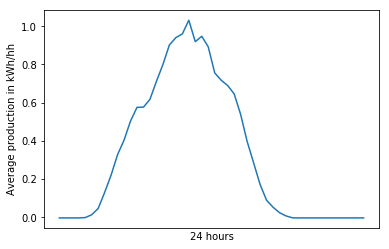

In [17]:
plt.xticks([])
plt.xlabel('24 hours')
plt.ylabel('Average production in kWh/hh')
plt.plot(df_store.index[0:48],df_store.mean(axis=1)[0:48])